# Naver sentiment movie corpus
- 이 데이터셋은 네이버 영화의 리뷰 중 영화당 100개의 리뷰를 모아 총 200,000개의 리뷰(train: 15만, test: 5만)로 이루져있습니다. 

- 1-10점까지의 평점 중에서 중립적인 평점(5-8점)은 제외하고 1-4점을 긍정으로, 9-10점을 부정으로 동일한 비율로 데이터에 포함시켰습니다.

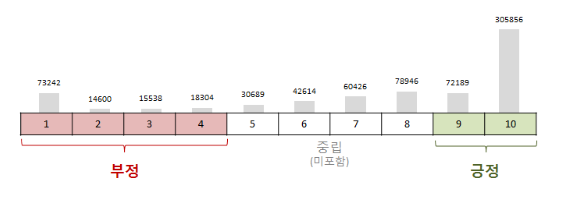

- 데이터는 id, document, label 세 개의 열로 이루어져있습니다. 

- id는 리뷰의 고유한 key 값이고, document는 리뷰의 내용, label은 긍정(0)인지 부정(1)인지를 나타냅니다. 

- txt로 저장된 데이터를 처리하기 알맞게 list 형식으로 받아서 사용하겠습니다.



# Data load & processing

이제 데이터를 학습하기에 알맞게 처리를 해볼텐데요, KoNLPy 라이브러리를 이용해서 형태소 분석 및 품사 태깅을 하겠습니다.

imdb 리뷰 분석 예제처럼 주어진 단어의 빈도만을 사용해서 처리해도 되지만 한국어는 영어와는 달리 띄어쓰기로 의미를 구분짓기에는 한계가 있고,

네이버 영화 데이터에는 맞춤법이나 띄어쓰기가 제대로 되어있지 않은 경우가 있기 때문에 정확한 분류를 위해서 KoNLPy를 이용하겠습니다.

KoNLPy는 띄어쓰기 알고리즘과 정규화를 이용해서 맞춤법이 틀린 문장도 어느 정도 고쳐주면서 형태소 분석과 품사를 태깅해주는 여러 클래스를 제공합니다. ([링크](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/) 참조)



전처리 과정
  1. 문장데이터 형태소 분석을 통해 단어로 구분 
  2. 나눠진 단어를 많이 등장하는 순서로 정렬해 단어 사전을 만든 후
  3. 문장 데이터를 단어의 인덱스로 변경하여 정수화
  4. 제로패딩으로 모든 문장 길이를 맞추고
  5.워드 임베딩을 통해 좀 더 밀집하게 표현


In [ ]:
from tensorflow.keras.utils import get_file

train_fname = 'ratings_train.tsv'
test_fname = 'ratings_test.tsv'
train_origin = 'https://raw.github.com/e9t/nsmc/master/ratings_train.txt'
test_origin = 'https://raw.github.com/e9t/nsmc/master/ratings_test.txt'

train_path = get_file(train_fname, train_origin)
test_path = get_file(test_fname, test_origin)

4898816/4893335 [==============================] - 0s 0us/step


In [ ]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data(train_path)
test_data = read_data(test_path)

In [ ]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

150000
3
50000
3


형태소 분석기 비교
- 빠른 속도와 보통의 정확도를 원한다면 "Komoran" 또는 "Hannanum"

- 속도는 느리더라도 정확하고 상세한 품사 정보를 원한다면 "Kkma"

- 어느 정도의 띄어쓰기 되어 있는 "인터넷" 영화평/상품명을 처리할 땐 "Okt"


In [ ]:
! pip install konlpy
import konlpy

konlpy.__version__

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 57.1MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


'0.5.2'

In [ ]:
from konlpy.tag import Komoran

Komoran = Komoran()
print(Komoran.pos(u'마지막 수업인데 오늘은 조금만 할까요? ㅎㅎ'))

[('마지막 수업', 'NNP'), ('이', 'VCP'), ('ㄴ데', 'EC'), ('오늘', 'NNG'), ('은', 'JX'), ('조금', 'NNG'), ('만', 'JX'), ('하', 'VX'), ('ㄹ까요', 'EF'), ('?', 'SF'), ('ㅎㅎ', 'NA')]


In [ ]:
from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'마지막 수업인데 오늘은 조금만 할까요? ㅎㅎ'))

[('마지막', 'Noun'), ('수업', 'Noun'), ('인데', 'Josa'), ('오늘', 'Noun'), ('은', 'Josa'), ('조금', 'Noun'), ('만', 'Josa'), ('할까', 'Verb'), ('요', 'Noun'), ('?', 'Punctuation'), ('ㅎㅎ', 'KoreanParticle')]


In [ ]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in Komoran.pos(doc)]

  

In [ ]:
train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

In [ ]:
test_docs[0]

(['굳/VV', 'ㅋ/NA'], '1')

In [ ]:
# JSON 파일로 저장
with open('train_docs_komoran.json', 'w', encoding="utf-8") as make_file:
    json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
with open('test_docs_komoran.json', 'w', encoding="utf-8") as make_file:
    json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])


(['아/IC',
  '더빙/NNP',
  './SF',
  './SF',
  '진짜/MAG',
  '짜증/NNG',
  '나/VV',
  '네요/EC',
  '목소리/NNG'],
 '0')


분석한 데이터의 토큰(문자열을 분석을 위한 작은 단위)의 갯수를 확인해봅시다.

In [ ]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2870289


이제 이 데이터를 nltk 라이브러리를 통해서 전처리를 해볼텐데요, Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공합니다.

In [ ]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


여기에서는 vocab().most_common 메서드를 이용해서 데이터에서 가장 자주 사용되는 단어를 가져올 때 사용하겠습니다.

In [ ]:
# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2870289
64912
[('./SF', 113151),
 ('ㄴ/ETM', 61446),
 ('이/VCP', 47640),
 ('는/ETM', 43176),
 ('고/EC', 42394),
 ('보/VV', 40179),
 ('하/XSV', 40074),
 ('영화/NNG', 39720),
 ('이/JKS', 38174),
 ('하/XSA', 33021)]


이제 자주 사용되는 토큰 10000개를 사용해서 데이터를 벡터화를 시키겠습니다.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48372 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_

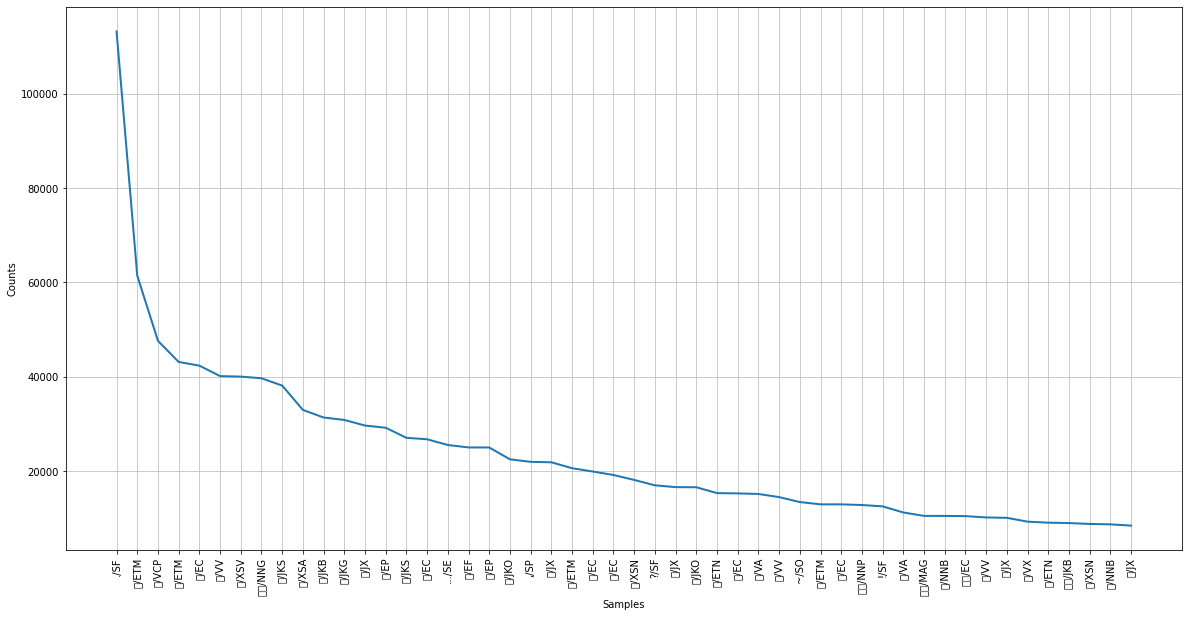

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

plt.figure(figsize=(20,10))
text.plot(50)

이제 자주 사용되는 토큰 10000개를 사용해서 데이터를 벡터화를 시키겠습니다.

여기서는 원 핫 인코딩 대신에 CountVectorization을 사용했습니다.

이는 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW(Bag of Words) 인코딩한 벡터를 만드는 역할을 합니다.

In [ ]:
selected_words = [f[0] for f in text.vocab().most_common(9999)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [ ]:
selected_words = [f[0] for f in text.vocab().most_common(9999)]

#train data
train_x = []
for i in range(len(train_docs)):
    _ = []
    for word in train_docs[i][0] :
        try : 
            _.append(selected_words.index(word))
        except :
            _.append(9999)
    train_x.append(_)
    
#test data
test_x = []
for i in range(len(test_docs)):
    _ = []
    for word in test_docs[i][0] :
        try : 
            _.append(selected_words.index(word))
        except :
            _.append(9999)
    test_x.append(_)

In [ ]:
selected_words.append('***/') # 10000위 안에 들지 못하는 단어들은 모두 ***라고 표기함

In [ ]:
selected_words[9999]

In [ ]:
import pickle

with open("nsmc_selected_words_komoran.txt", "wb") as fp:
    pickle.dump(selected_words, fp)  
with open("nsmc_train_x_komoran.txt", "wb") as fp:
    pickle.dump(train_x, fp)
with open("nsmc_test_x_komoran.txt", "wb") as fp:
    pickle.dump(test_x, fp)
with open("nsmc_train_y_komoran.txt", "wb") as fp:
    pickle.dump(train_y, fp)
with open("nsmc_test_y_komoran.txt", "wb") as fp:
    pickle.dump(test_y, fp)

# Open pre-processing data

In [ ]:
import pickle
import numpy as np
#load 
with open("nsmc_train_x.txt", "rb") as fp:
    X_train = pickle.load(fp)
with open("nsmc_test_x.txt", "rb") as fp:
    X_test = pickle.load(fp)
with open("nsmc_train_y.txt", "rb") as fp:
    train_y = pickle.load(fp)
with open("nsmc_test_y.txt", "rb") as fp:
    test_y = pickle.load(fp)
with open("nsmc_selected_words.txt", "rb") as fp:
    selected_words_10000 = pickle.load(fp)

# LSTM Training

In [ ]:
import numpy as np
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Model, load_model

import matplotlib.pyplot as plt
from IPython.display import display, HTML

from numpy import newaxis as na

In [ ]:
max_features = 10000
maxlen = 100
batch_size = 1024

In [ ]:
# One-hot encoding the output >> 
num_classes = 2
y_train = keras.utils.to_categorical(train_y, num_classes)
y_test = keras.utils.to_categorical(test_y, num_classes)

In [ ]:
print('훈련 데이터: {}'.format(len(X_train)))
print('테스트 데이터: {}'.format(len(X_test)))
print('카테고리: {}'.format(num_classes))

훈련 데이터: 150000
테스트 데이터: 50000
카테고리: 2


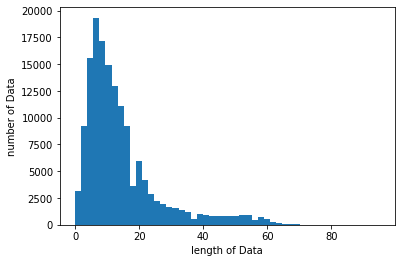

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

입력 문장의 길이가 서로 달라서 max_len보다 긴 문장은 max_len까지 자르고, max_len보다 짧은 문장은 max_len까지 0으로 채움

max_len값을 결정하기 위해 전체 데이터의 길이 분포를 고려

In [ ]:
maxlen = 30
x_train = sequence.pad_sequences(X_train, maxlen) # 길이 잘라줌
x_test = sequence.pad_sequences(X_test, maxlen)

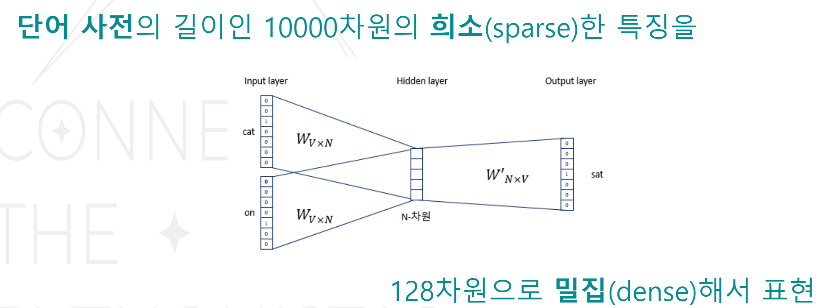

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 1,411,842
Trainable params: 1,411,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3)

Train...
Epoch 1/3
147/147 [==============================] - 21s 146ms/step - loss: 0.4459 - accuracy: 0.7921
Epoch 2/3
147/147 [==============================] - 22s 148ms/step - loss: 0.3245 - accuracy: 0.8591
Epoch 3/3
147/147 [==============================] - 21s 144ms/step - loss: 0.3057 - accuracy: 0.8677


In [ ]:
model.evaluate(x_test, y_test)

1563/1563 [==============================] - 16s 10ms/step - loss: 0.3437 - accuracy: 0.8462


[0.3437347710132599, 0.8461599946022034]

# LRP & Visualization

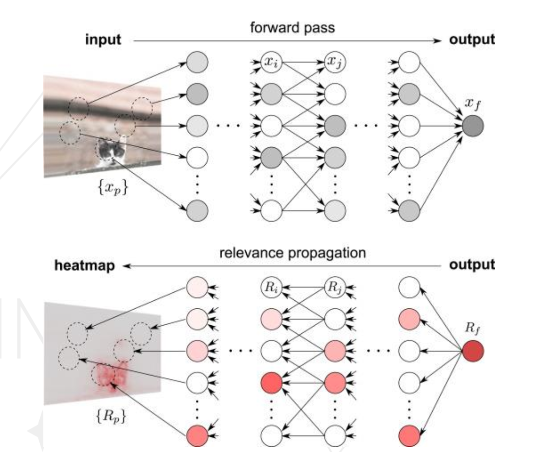

입력 데이터 관점에서 분류 결과 뿐만 아니라 결정에 영향을 미치는 구조 설명

Layer-wise: 레이어단위로

Relevance: 결과에 영량을 주는 관련성을 구하는

Propagation: 역전파 기술

아래 공개된 코드는 학습된 가중치를 불러와 LRP에 적용, 코드가 복잡해 커스터마이증 어려움


In [ ]:
def html_heatmap (words, scores, cmap_name="bwr"):
    """
    Return word-level heatmap in HTML format,
    with words being the list of words (as string),
    scores the corresponding list of word-level relevance values,
    and cmap_name the name of the matplotlib diverging colormap.
    """
    
    colormap  = plt.get_cmap(cmap_name)
     
    #assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

def rescale_score_by_abs (score, max_score, min_score):
    """
    Normalize the relevance value (=score), accordingly to the extremal relevance values (max_score and min_score), 
    for visualization with a diverging colormap.
    i.e. rescale positive relevance to the range [0.5, 1.0], and negative relevance to the range [0.0, 0.5],
    using the highest absolute relevance for linear interpolation.
    """
    
    # CASE 1: positive AND negative scores occur --------------------
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur -----------------------------       
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur -----------------------------
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)
          

def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"

In [ ]:
class LRP4LSTM(object):
    def __init__(self, model):
        self.model = model
        
        names = [weight.name for layer in model.layers for weight in layer.weights]
        print(names)
        weights = model.get_weights()
        # suppress scientific notation
        # ['embedding/embeddings:0', 'lstm/lstm_cell/kernel:0', 'lstm/lstm_cell/recurrent_kernel:0', 'lstm/lstm_cell/bias:0', 'dense/kernel:0', 'dense/bias:0']
        np.set_printoptions(suppress=True)
        for name, weight in zip(names, weights):
            if name == 'lstm/lstm_cell/kernel:0':
                kernel_0 = weight
            if name == 'lstm/lstm_cell/recurrent_kernel:0':
                recurrent_kernel_0 = weight
            if name == 'lstm/lstm_cell/bias:0':
                bias_0 = weight
            elif name == 'dense/kernel:0':
                output = weight


        print("kernel_0", kernel_0.shape)
        print("recurrent_kernel_0", recurrent_kernel_0.shape)
        print("bias_0", bias_0.shape)
        print("output", output.shape)

        # self.Wxh_Left (240, 60)
        # self.Whh_Left (240, 60)
        # self.bxh_Left (240,)
        # self.Why_Left (5, 60)

        self.Wxh = kernel_0.T  # shape 4d*e
        self.Whh = recurrent_kernel_0.T  # shape 4d
        self.bxh = bias_0.T  # shape 4d 
        self.Why = output.T
        
    def lrp_linear(self, hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=1.0, debug=False):
        """
        LRP for a linear layer with input dim D and output dim M.
        Args:
        - hin:            forward pass input, of shape (D,)
        - w:              connection weights, of shape (D, M)
        - b:              biases, of shape (M,)
        - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
        - Rout:           relevance at layer output, of shape (M,)
        - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
        - eps:            stabilizer (small positive number)
        - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
        Returns:
        - Rin:            relevance at layer input, of shape (D,)
        """
        sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)

        numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
        # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
        # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
        # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)

        denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)

        message  = (numer/denom) * Rout[na,:]       # shape (D, M)

        Rin      = message.sum(axis=1)              # shape (D,)

        if debug:
            print("local diff: ", Rout.sum() - Rin.sum())
        # Note: 
        # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
        # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
        # -> can be used for sanity check

        return Rin
        
    def get_layer_output(self, layer_name, data):
        # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                         outputs=self.model.get_layer(layer_name).output)
        return intermediate_layer_model.predict(data)  
    
    def run(self, target_data, target_class):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        #원본 소스에서 E embedding은 전체에 대한 단어 사전이고, x는 embedding된 인풋이다.  
        # w_indices [109, 11995, 25, 18263, 25, 973, 3138, 6389, 372]
        
        x = self.get_layer_output('embedding', target_data).squeeze(axis=1)
        e = x.shape[1]

       ################# forword
        T = target_data.shape[0]
        d = int(512/4)  # hidden units
        C = self.Why.shape[0] # number of classes

        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_f, idx_c, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately

        # 최종적으로 구하려는 값은 c에 저장될 값과 h으로 지워질 값
        h  = np.zeros((T,d))
        c  = np.zeros((T,d))

        gates_pre = np.zeros((T, 4*d))  # gates pre-activation
        gates     = np.zeros((T, 4*d))  # gates activation

        for t in range(T):

            gates_pre[t]    = np.dot(self.Wxh, x[t]) + np.dot(self.Whh, h[t-1]) + self.bxh

            gates[t,idx]    = sigmoid(gates_pre[t,idx])
            gates[t,idx_c]  = np.tanh(gates_pre[t,idx_c]) 

            c[t]            = gates[t,idx_f]*c[t-1] + gates[t,idx_i]*gates[t,idx_c]
            h[t]            = gates[t,idx_o]*np.tanh(c[t])

        score = np.dot(self.Why, h[t])    

        ################# backwork
        dx     = np.zeros(x.shape)

        dh          = np.zeros((T, d))
        dc          = np.zeros((T, d))
        dgates_pre  = np.zeros((T, 4*d))  # gates pre-activation
        dgates      = np.zeros((T, 4*d))  # gates activation

        ds               = np.zeros((C))
        ds[target_class] = 1.0
        dy               = ds.copy()

        #맨처음을 0으로 시작하지 않게 위한조치
        dh[T-1]     = np.dot(self.Why.T, dy)

        for t in reversed(range(T)): 
            dgates[t,idx_o]    = dh[t] * np.tanh(c[t])  # do[t]
            dc[t]             += dh[t] * gates[t,idx_o] * (1.-(np.tanh(c[t]))**2) # dc[t]
            dgates[t,idx_f]    = dc[t] * c[t-1]         # df[t]
            dc[t-1]            = dc[t] * gates[t,idx_f] # dc[t-1]
            dgates[t,idx_i]    = dc[t] * gates[t,idx_c] # di[t]
            dgates[t,idx_c]    = dc[t] * gates[t,idx_i] # dg[t]
            dgates_pre[t,idx]  = dgates[t,idx] * gates[t,idx] * (1.0 - gates[t,idx]) # d ifo pre[t]
            dgates_pre[t,idx_c]= dgates[t,idx_c] *  (1.-(gates[t,idx_c])**2) # d c pre[t]
            dh[t-1]            = np.dot(self.Whh.T, dgates_pre[t])
            dx[t]              = np.dot(self.Wxh.T, dgates_pre[t])

        ################# LRP
        eps=0.001 
        bias_factor=1.0
        Rx  = np.zeros(x.shape)
        Rh  = np.zeros((T+1, d))
        Rc  = np.zeros((T+1, d))
        Rg  = np.zeros((T,   d)) # gate g only

        Rout_mask            = np.zeros((C))
        Rout_mask[target_class] = 1.0  

        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        Rh[T-1]  = self.lrp_linear(h[T-1], self.Why.T, np.zeros((C)), score, score*Rout_mask, d, eps, bias_factor, debug=False)  

        for t in reversed(range(T)):
            Rc[t]   += Rh[t]
            Rc[t-1]  = self.lrp_linear(gates[t,idx_f]*c[t-1], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
            Rg[t]    = self.lrp_linear(gates[t,idx_i]*gates[t,idx_c], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
            Rx[t]    = self.lrp_linear(x[t], self.Wxh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)
            Rh[t-1]  = self.lrp_linear(h[t-1], self.Whh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)    

        return score, x, dx, Rx, Rh[-1].sum()

In [ ]:
lrp = LRP4LSTM(model)

['embedding/embeddings:0', 'lstm/lstm_cell/kernel:0', 'lstm/lstm_cell/recurrent_kernel:0', 'lstm/lstm_cell/bias:0', 'dense/kernel:0', 'dense/bias:0']
kernel_0 (128, 512)
recurrent_kernel_0 (128, 512)
bias_0 (512,)
output (128, 2)


In [ ]:
def index_to_word(list):
    _ = []
    for x in list :
        _.append(selected_words_10000[x].split('/')[0])
    return _
  
def int_to_str(target_class):
    if target_class == 0 :
        return "부정"
    else :
        return "긍정"

In [ ]:
predictions = model.predict(x_test)

In [ ]:
positive_list = []
negative_list = []

for i in range(len(y_test)):
    if np.argmax(predictions[i]) == 1:
        positive_list.append(i)
    else :
        negative_list.append(i)

In [ ]:
positive_list[:5]

[0, 5, 9, 10, 12]

In [ ]:
negative_list[:5]

[1, 2, 3, 4, 6]

In [ ]:
print("각 단어가 긍정이라고 예측하는데 영향을 미치는 정도" )
for index, i in enumerate(positive_list):
    
    target_full_data = x_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(y_test[i])

    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = index_to_word(target_data) 

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("        SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("        LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

        print("-----------------------------------------------------------")

    if index == 20: # 20roaks 출력
      break

각 단어가 긍정이라고 예측하는데 영향을 미치는 정도
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 긍정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


In [ ]:
print("각 단어가 부정이라고 예측하는데 영향을 미치는 정도" )
for index, i in enumerate(negative_list):
    
    target_full_data = x_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(y_test[i])

    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = index_to_word(target_data) 

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("        SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("        LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

        print("-----------------------------------------------------------")

    if index == 20: # 20roaks 출력
      break

각 단어가 부정이라고 예측하는데 영향을 미치는 정도
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  긍정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------
 예측 레이블: 부정 | 실제 레이블 :  부정
        SA heatmap:


        LRP heatmap:


-----------------------------------------------------------


## 실습
- 위 전반적인 감정 분석 과정 
- 형태소 분석기 변환
- 토큰화 10000 -> 1000
- LSTM 설계
- LRP